| Етап (UKR)                     | Задачі (UKR)                                                                                                                                                                                                                         | Stage (ENG)                      | Tasks (ENG)                                                                                                                                                                                                                                                   |
| ------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1. Підготовка даних            | • Завантажити датасет «Signs (Fingers)»<br>• Розбити на train/validation/test<br>• Нормалізувати пікселі (0–1)<br>• One‑hot кодування міток                                                                                          | 1. Data Preparation              | • Load the “Signs (Fingers)” dataset<br>• Split into train/validation/test sets<br>• Normalize pixel values (0–1)<br>• One‑hot encode the labels                                                                                                              |
| 2. Базова модель               | • Сконструювати просту MLP/CNN <br>• Визначити критерій зупинки та метрики (accuracy, loss)                                                                                             | 2. Baseline Model                | • Construct a simple MLP/CNN <br>• Define stopping criterion and metrics (accuracy, loss)                                                                                                                            |
| 3. Дослідження гіперпараметрів | • **Кількість шарів:** моделі з 1, 2, 3 Dense/CNN‑шарів (ReLU, Dropout=0.2)<br>• **Активація:** для 2‑шарової архітектури ReLU vs tanh vs sigmoid (Dropout=0.2)<br>• **Dropout:** для оптимальної конфігурації Dropout=0.0, 0.2, 0.5 | 3. Hyperparameter Exploration    | • **Number of layers:** models with 1, 2, and 3 Dense/CNN layers (ReLU, Dropout=0.2)<br>• **Activation:** compare ReLU vs tanh vs sigmoid on 2‑layer architecture (Dropout=0.2)<br>• **Dropout ratio:** test Dropout=0.0, 0.2, 0.5 for the best configuration |
| 4. Аналіз результатів          | • Визначити найкращу конфігурацію за валідаційною accuracy<br>• Оцінити модель на тестовій вибірці<br>• Провести аналіз помилок (confusion matrix)                                                                                   | 4. Results Analysis              | • Identify the best configuration by validation accuracy<br>• Evaluate the model on the held‑out test set<br>• Perform error analysis (confusion matrix)                                                                                                      |
| 5. Висновки й рекомендації     | • Зробити висновки щодо впливу гіперпараметрів на збіжність та якість<br>• Сформулювати рекомендації для подальших експериментів                                                                                                     | 5. Conclusions & Recommendations | • Draw insights on how each hyperparameter affects convergence and performance<br>• Formulate recommendations for future experiments                                                                                                                          |

---
### **Основна ціль домашнього завдання (UKR) / Main objective of the homework (ENG) :**
- Логічно спроектувати та реалізувати нейронну мережу для класифікації датасету «Signs (Fingers)», дослідити вплив гіперпараметрів (глибина мережі, функція активації, рівень Dropout) шляхом серії експериментів, і надати звіт із порівнянням результатів (validation accuracy, loss, графіки збіжності, confusion matrix).

- Logically design and implement a neural network for the “Signs (Fingers)” classification dataset, investigate the impact of hyperparameters (network depth, activation function, dropout ratio) through a series of experiments, and deliver a report comparing results (validation accuracy, loss, convergence plots, confusion matrix).

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
def load_dataset():
    fn = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/Train Signs.h5'
    train_dataset = h5py.File(fn, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels

    fn = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/Test Signs.h5'
    test_dataset =  h5py.File(fn, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    Y_test = Y_test.reshape((1, Y_test.shape[0]))

    return X_train, Y_train, X_test, Y_test, classes
train_data, train_labels, test_data, test_labels, classes = load_dataset()

print ('train_data.shape=', train_data.shape)
print ('train_labels.shape=',  train_labels.shape)
print ('test_data.shape=', test_data.shape)
print ('test_labels.shape=', test_labels.shape)


train_data.shape= (1080, 64, 64, 3)
train_labels.shape= (1, 1080)
test_data.shape= (120, 64, 64, 3)
test_labels.shape= (1, 120)


In [ ]:
def display_samples_in_grid(X, n_rows, n_cols= None, y = None ):
    if n_cols is None:
        n_cols= n_rows
    indices = np.random.randint(0, len(X),n_rows*n_cols)
    for i in range (n_rows):
        for j in range (n_cols):
            index = n_cols*i+j
            ax = plt.subplot(n_rows,n_cols,index+1)
            ax.imshow(X[indices[index]], cmap='Greys')
            if not (y is None):
                plt.title(y[indices[index]])
            plt.axis('off')


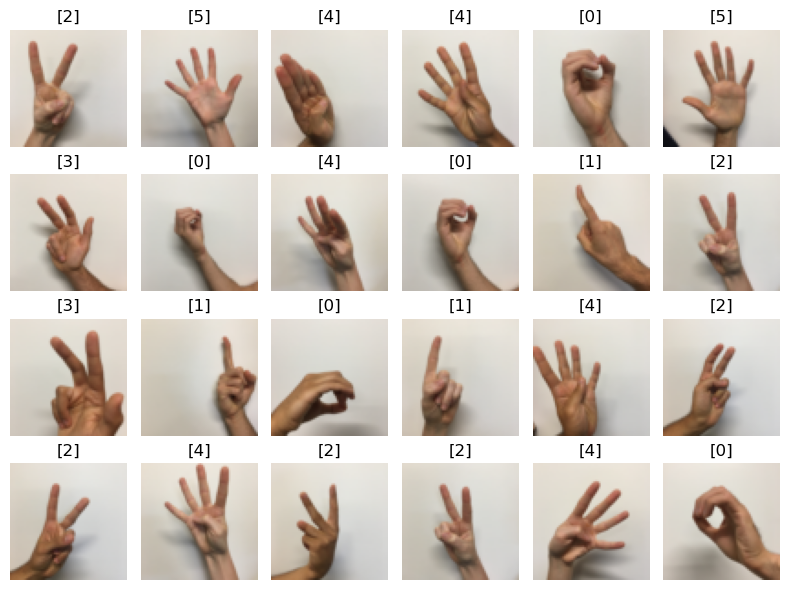

In [ ]:
plt.figure(figsize=(8,6))
display_samples_in_grid(train_data, n_rows=4, n_cols=6, y=train_labels.T)
plt.tight_layout(h_pad=1, w_pad=1)


## Основні практичні випадки нормалізації пікселів

| Джерело даних                                            | Тип              | Діапазон       | Нормалізація                                       |
| -------------------------------------------------------- | ---------------- | -------------- | -------------------------------------------------- |
| Стандартне PNG/JPEG зображення                           | uint8            | 0–255          | /255.0                                             |
| Медичні DICOM або TIFF                                   | uint16           | 0–65535        | /65535.0                                           |
| RAW-зображення з телескопа                               | uint16 або int16 | -32 768…32 767 | / 32 767.0 або власна нормалізація                 |
| Зображення, зчитані tf.keras.datasets (наприклад, MNIST) | uint8            | 0–255          | /255.0                                             |
| TFDS (TensorFlow datasets)                               | float32          | 0–1 або -1 … 1 | Часто вже нормалізовані                            |
| Spectrogram аудіо                                        | float32          | різне          | Часто нормалізують у \[-1, 1] або 0 mean, unit std |


In [14]:
def inspect_image_data(data):
    print(f'Data type: {data.dtype}')
    print(f'Min pixel value: {np.min(data)}')
    print(f'Max pixel value: {np.max(data)}')

inspect_image_data(train_data)


Data type: uint8
Min pixel value: 4
Max pixel value: 244


In [ ]:
X_train = train_data/255.0
X_test = test_data/255.0

inspect_image_data(X_train), inspect_image_data(X_test)


Data type: float64
Min pixel value: 0.01568627450980392
Max pixel value: 0.9568627450980393
Data type: float64
Min pixel value: 0.011764705882352941
Max pixel value: 0.9450980392156862


(None, None)

| Числове значення | Для людини | Для моделі          |
| ---------------- | ---------- | ------------------- |
| 3                | клас №3    | \[0, 0, 0, 1, 0, 0] |
| 1                | клас №1    | \[0, 1, 0, 0, 0, 0] |
| 0                | клас №0    | \[1, 0, 0, 0, 0, 0] |


In [ ]:
train_labels.shape, test_labels.shape


((1, 1080), (1, 120))

In [ ]:
y_train_flat = train_labels.flatten()
y_test_flat = test_labels.flatten()

print(y_train_flat.shape, y_test_flat.shape)
print(np.unique(y_train_flat))
print(len(np.unique(y_train_flat)))
print(classes)


(1080,) (120,)
[0 1 2 3 4 5]
6
[0 1 2 3 4 5]


In [ ]:
from tensorflow.keras.utils import to_categorical # type: ignore

y_train_oh = to_categorical(y_train_flat)
y_test_oh = to_categorical(y_test_flat)

print(y_train_oh.shape)
print(y_test_oh.shape)

print(y_train_oh[0])


(1080, 6)
(120, 6)
[0. 0. 0. 0. 0. 1.]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, CSVLogger  # type: ignore


In [ ]:
INPUT_SHAPE = train_data.shape[1:]

print(INPUT_SHAPE)


(64, 64, 3)


In [ ]:
static_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])


In [ ]:
def build_model(num_hidden_layers=1,
                hidden_units=128,
                activation='relu',
                dropout_rate=0.3,
                num_classes=6):

    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))

    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_and_evaluate(model, X_train, Y_train_oh, X_test, Y_test_oh, epochs=20):
    history = model.fit(X_train, Y_train_oh,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_test, Y_test_oh),
                        verbose=1)

    test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=1)
    print(f'Test accuracy: {test_acc:.4f}')
    return history, test_acc


In [41]:
configs = [
    {'num_hidden_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3},
    {'num_hidden_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.2},
    {'num_hidden_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.5},
]

results = []
for conf in configs:
    print(f"Training model with config: {conf}")
    model = build_model(num_hidden_layers=conf['num_hidden_layers'],
                        activation=conf['activation'],
                        dropout_rate=conf['dropout_rate'],
                        num_classes=6)
    _, acc = train_and_evaluate(model, X_train, y_train_oh, X_test, y_test_oh)
    results.append((conf, acc))

print("Summary of results:")
for conf, acc in results:
    print(f"Config: {conf}, Test accuracy: {acc:.4f}")


Training model with config: {'num_hidden_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1741 - loss: 7.8853 - val_accuracy: 0.1667 - val_loss: 1.7916
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1498 - loss: 1.7917 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1514 - loss: 1.7920 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1606 - loss: 1.7918 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1607 - loss: 1.7918 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1813 - loss: 1.7918 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1416 - loss: 1.7919 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1663 - loss: 1.7918 - val_accuracy: 0.1667 - v

In [ ]:
results


[({'num_hidden_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3},
  0.1666666716337204),
 ({'num_hidden_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.2},
  0.1666666716337204),
 ({'num_hidden_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.5},
  0.1666666716337204)]